In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import callbacks,optimizers
import keras

In [ ]:
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_dataset = train.flow_from_directory('/content/drive/MyDrive/dataset/train',
                                          target_size=(200,200),
                                          batch_size=32,
                                          class_mode='categorical')

validation_dataset = validation.flow_from_directory('/content/drive/MyDrive/dataset/test',
                                          target_size=(200,200),
                                          batch_size=32,
                                          class_mode='categorical')

Found 3164 images belonging to 11 classes.
Found 725 images belonging to 11 classes.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/anjHOG.csv', header=None)
df.head()

,0
0,0.035639
1,0.111797
2,0.255989
3,0.060508
4,0.072334


In [ ]:
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
visible = Input(shape=(200,200,3))
conv1 = Conv2D(16,(3,3), input_shape=(200,200,3), activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32,(3,3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64,(3,3), activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)
concat_ = keras.layers.Concatenate()([flat, df])
hidden1 = Dense(512, activation='relu')(flat)
output = Dense(11, activation='softmax')(hidden1)
model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import keras.backend as K

def f1_score(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss= 'categorical_crossentropy',
              optimizer = RMSprop(learning_rate=0.001),
              metrics=['Precision','accuracy','Recall','AUC',f1_score])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(train_dataset )
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(train_dataset.classes, y_pred))
print('Classification Report')
target_names = ['0', '1','2','3','4','5','6','7','8','9','10']
print(classification_report(train_dataset.classes, y_pred, target_names=target_names))

Confusion Matrix
[[221  16 312   0   0   3   0   0   0   0   0]
 [283  28 347   0   0  10   0   0   0   0   0]
 [ 51   5  55   0   0   2   0   0   0   0   1]
 [ 93  12 107   0   0   5   0   0   0   0   0]
 [ 34   4  64   0   0   4   0   0   0   0   0]
 [ 56   2  79   0   0   0   0   0   0   0   0]
 [ 35   3  31   0   0   0   0   0   0   0   0]
 [273  18 299   0   1  14   0   0   0   0   1]
 [ 47   5  61   0   0   4   0   0   0   0   0]
 [189  15 225   0   0  11   0   0   0   0   0]
 [ 65   1  70   0   0   2   0   0   0   0   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.16      0.40      0.23       552
           1       0.26      0.04      0.07       668
           2       0.03      0.48      0.06       114
           3       0.00      0.00      0.00       217
           4       0.00      0.00      0.00       106
           5       0.00      0.00      0.00       137
           6       0.00      0.00      0.00        69
          

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
h = model.fit(train_dataset, epochs=2, validation_data=validation_dataset)

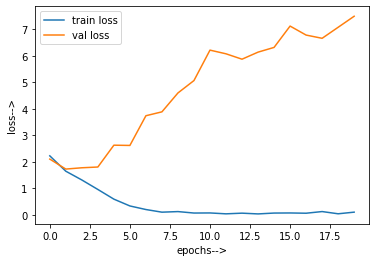

In [ ]:
import matplotlib.pyplot as plt
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('LossVal_loss')
plt.xlabel('epochs-->')
plt.ylabel('loss-->')
plt.show()

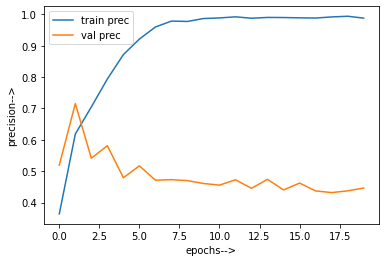

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot the precision
plt.plot(h.history['precision'], label='train prec')
plt.plot(h.history['val_precision'], label='val prec')
plt.legend()
plt.xlabel('epochs-->')
plt.ylabel('precision-->')
plt.show()
plt.savefig('AccVal_prec')

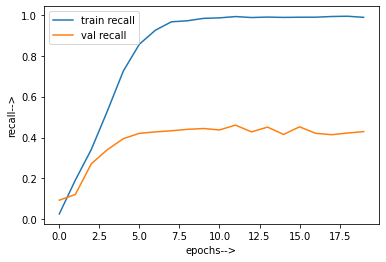

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot recall
plt.plot(h.history['recall'], label='train recall')
plt.plot(h.history['val_recall'], label='val recall')
plt.legend()
plt.xlabel('epochs-->')
plt.ylabel('recall-->')
plt.show()
plt.savefig('AccVal_rec')

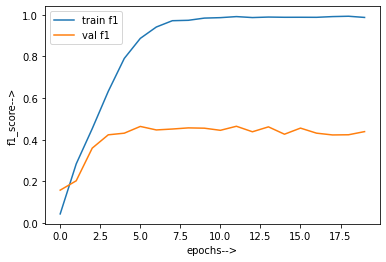

<Figure size 432x288 with 0 Axes>

In [ ]:

#plot f1_score
plt.plot(h.history['f1_score'], label='train f1')
plt.plot(h.history['val_f1_score'], label='val f1')
plt.legend()
plt.xlabel('epochs-->')
plt.ylabel('f1_score-->')
plt.show()
plt.savefig('AccVal_f1')

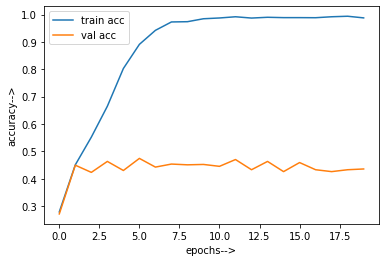

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the accuracy
plt.plot(h.history['accuracy'], label='train acc')
plt.plot(h.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('epochs-->')
plt.ylabel('accuracy-->')
plt.show()
plt.savefig('AccVal_acc')

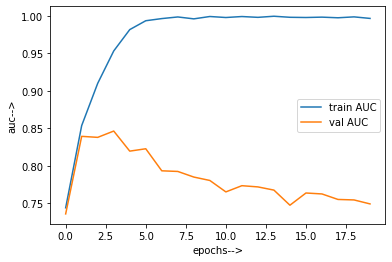

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(h.history['auc'], label='train AUC')
plt.plot(h.history['val_auc'], label='val AUC')
plt.legend()
plt.xlabel('epochs-->')
plt.ylabel('auc-->')
plt.show()
plt.savefig('AUCVal_AUC')

val [[0.000000e+00 9.683096e-23 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00]]
sadly disgusted 6


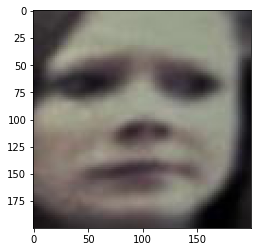

In [ ]:
img=image.load_img('/content/drive/MyDrive/dataset/test/6/test_005_aligned.jpg',target_size=(200,200))
plt.imshow(img)
X=image.img_to_array(img)
X=np.expand_dims(X,axis=0)
images=np.vstack([X])
val=model.predict(images)
print("val %s"%val)
rach=val.argmax()
if rach==0:
  print("happily surprised 1")

if rach==1:
  print("angrily disgusted 10")

if rach==2:
  print("disgustedly surprised 11")

if rach==3:
  print("happily disgusted 2")

if rach==4:
  print("sadly fearful 3")

if rach==5:
  print("sadly angry 4")

if rach==6:
  print("sadly surprised 5")

if rach==7:
  print("sadly disgusted 6")

if rach==8:
  print("fearfully angry 7")

if rach==9:
  print("fearfully surprised 8")

if rach==10:
  print("angrily surprised 9")


In [ ]:

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      //await new Promise((resolve) => capture.onclick = resolve);
      capture.onclick
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



In [ ]:
import time
counter_time = 0
while True:
   time.sleep(8)
   counter_time = counter_time + 1
   if counter_time== 3 or 23 :
    from IPython.display import Image
    try:
       filename = take_photo()
       print('Saved to {}'.format(filename))
       display(Image(filename))
    except Exception as err:
       print(str(err))
   if counter_time== 6 or 26 :
       img=image.load_img('/content/photo.jpg',target_size=(200,200))
       plt.imshow(img)
       X=image.img_to_array(img)
       X=np.expand_dims(X,axis=0)
       images=np.vstack([X])
       val=model.predict(images)
       print("val %s"%val)
       rach=val.argmax()
       if rach==0:
         print("Happily Surprised")
       if rach==1:
         print("Happily Disgusted")
       if rach==2:
         print(" Sadly Fearful")
       if rach==3:
         print("Sadly Angry")
       if rach==4:
         print(" Sadly Surprised")
       if rach==5:
         print("Sadly Disgusted")
       if rach==6:
         print(" Fearfully Angry")
       if rach==7:
         print("Fearfully Surprised")
       if rach==8:
         print("Angrily Surprised")
       if rach==9:
         print("Angrily Disgusted")
       if rach==10:
         print("Disgustedly Surprised")


